# Random Acts of Pizza (RAOP) Notes

**Source**: Althoff, T., Danescu-Niculescu-Mizil, C., & Jurafsky, D. (2014). *How to Ask for a Favor: A Case Study on the Success of Altruistic Requests*. Association for the Advancement of Artificial
Intelligence (www.aaai.org).

- "The community only publishes which users have given or received pizzas but not which requests were successful. 
In the case of successful users posting multiple times it is unclear which of the requests was actually successful. 
Therefore, we restrict our analysis to users with a single request for which we can be certain whether or not 
it was successful, leaving us with 5728 pizza requests. We split this dataset into development (70%) and test set (30%) such that both sets mirror the average success rate in our dataset of 24.6%. All features are developed on the 
development test only while the test set is used only once to evaluate the prediction accuracy of our proposed model on held-out data. For a small number of requests (379) we further observe the identity of the benefactor through a 
'thank you' post by the beneficiary after the successful request. This enables us to reason about the impact of 
user similarity on giving."


- "It is extremely difficult to disentangle the effects of all these factors in determining what makes people satisfy requests, and what makes them select some requests over others. . . In this paper, we develop a framework for controlling for each of these potential confounds while studying the role of two aspects that characterize compelling requests: **social factors** (who is asking and how the recipient is related to the donor and community) and **linguistic factors** (how they are asking and what linguistic devices accompany successful requests). With the notable exception of Mitra and Gilbert (2014), the effect of language on the success of requests has largely been ignored thus far."


- "[Their] goal is to understand what motivates people to give when they do not receive anything tangible in return. That is, [they] focus on the important special case of altruistic requests in which the giver receives no rewards." **DSC**: But how do you know people don't want something in return, especially if they are more likely to help requesters who have high status or are more similar to them?

-----

Temporal Factors
- Specific months
- Weekdays
- **Days of the month (first half of the month)**
- Hour of the day
- **Community age of the request (earlier the better)**

Textual Factors
- Politeness (e.g., **gratitude**)
- **Evidentiality** (2nd largest parameter estimate)
- Reciprocity (respond to a positive action with another positive action, **pay it forward**)
- Sentiment (e.g., **urgency**)
- **Length**

Social Factors
- **Status**
    - karma points (up-votes minus down-votes) that Reddit counts on link submissions and comments,
    - user has posted on RAOP before and thus could be considered a member of the sub-community. 
    - **user account age based on the hypothesis that “younger” accounts might be less trusted**


- Similarity: intersection size between the set of the giver and receiver, and the Jaccard similarity (intersection
over union) of the two. NOT included in logistic regression model.

Narratives (identified through topic modeling)
- **Desire**
- **Family**
- **Job**
- **Money**
- Student

-----

Conclusion
- Drawing from social psychology literature [they] extract high-level social features from text that operationalize the relation between recipient and donor and demonstrate that these extracted relations are predictive of success. 
- [They] show that [they] can detect key narratives automatically that have significant impact on the success of the request. 
- [They] further demonstrate that linguistic indications of gratitude, evidentiality, and reciprocity, as well as the high status of the asker, all increase the likelihood of success, while neither politeness nor positive sentiment seem to be associated with success in [the] setting.

Limitations
- A shortcoming of any case study is that findings might be specific to the scenario at hand. While [they] have shown that particular linguistic and social factors differentiate between successful and unsuccessful requests [they] cannot claim a causal relationship between the proposed factors and success that would guarantee success. 
- Furthermore, the set of success factors studied in this work is likely to be incomplete as well and excludes,
for instance, group behavior dynamics. 
- Despite these limitations, [they] hope that this work and the data [they] make available will provide a basis for further research on success factors and helping behavior in other online communities.

-----

In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import os
import codecs
import json
import csv

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

# Data Exploration

In [3]:
# http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_json.html
# Convert a JSON string to pandas object

X = pd.read_json('./pizza_request_dataset.json')
print ("type(X)", type(X))
print

# set random seed
np.random.seed(0)

# randomly assign 70% to train_data, and 30% to dev_data
msk = np.random.rand(len(X)) <= 0.7
train_data = X[msk]
dev_data = X[~msk]

# create output dataframe Y of train_labels
train_labels = train_data[["requester_received_pizza"]]

# delete train_labels from input dataframe of train_data
del train_data["requester_received_pizza"]

# create output dataframe of dev_labels
dev_labels = dev_data[["requester_received_pizza"]]

# delete dev_labels from input dataframe of dev_data
del dev_data["requester_received_pizza"]

# print (labels, shapes, and feature names
print ("train_labels" )
print ("----------")
print (list(train_labels))
print (train_labels.shape), "/n"
print ("train_data" )
print ("----------")
print (list(train_data))
print (train_data.shape), "/n"


print ("dev_labels") 
print ("----------")
print (list(dev_labels))
print (dev_labels.shape), "/n"

print ("dev_data")
print ("----------")
print (list(dev_data))
print (dev_data.shape), "/n"

# print (percent of train_data and dev_data whose posts led to receipt of pizza
print ("train labels")
print ("----------")
print (np.mean(train_labels)), "/n"
print ("dev labels")
print ("----------")
print (np.mean(dev_labels))

('type(X)', <class 'pandas.core.frame.DataFrame'>)

train_labels
----------
[u'requester_received_pizza']
(3975, 1) /n
train_data
----------
[u'giver_username_if_known', u'in_test_set', u'number_of_downvotes_of_request_at_retrieval', u'number_of_upvotes_of_request_at_retrieval', u'post_was_edited', u'request_id', u'request_number_of_comments_at_retrieval', u'request_text', u'request_text_edit_aware', u'request_title', u'requester_account_age_in_days_at_request', u'requester_account_age_in_days_at_retrieval', u'requester_days_since_first_post_on_raop_at_request', u'requester_days_since_first_post_on_raop_at_retrieval', u'requester_number_of_comments_at_request', u'requester_number_of_comments_at_retrieval', u'requester_number_of_comments_in_raop_at_request', u'requester_number_of_comments_in_raop_at_retrieval', u'requester_number_of_posts_at_request', u'requester_number_of_posts_at_retrieval', u'requester_number_of_posts_on_raop_at_request', u'requester_number_of_posts_on_raop_at_retrie

In [4]:
# prepare data
# transform X to numpy array, and Y to 1-D numpy array
# view actual text and labels

train_text = train_data["request_text"]
dev_text = dev_data["request_text"]

print ("type(train_text)", type(train_text))
print ("type(train_labels)", type(train_labels))
print ("type(dev_text)", type(dev_text))
print ("type(dev_labels)", type(dev_labels)), "/n"


# view as pandas dataframe
print ("pandas dataframe:")
print (train_text[:10]), "/n"

# convert to numpy (np) array

def to_np(d):

    print ("numpy.ndarray:")
    d = np.array(d)
    # http://stackoverflow.com/questions/13730468/from-2d-to-1d-arrays
    d = d.flatten()
    print (type(d))
    print (d.shape)
    print (d[:3])
    print
    return d

train_text = to_np(train_text)
train_labels = to_np(train_labels)
dev_text = to_np(dev_text)
dev_labels = to_np(dev_labels)

# convert to list

def to_list(d):

    print ("list:")
    d = list(d)
    print (type(d))
    print (d[:3])
    print ()
    return d


print ("train_labels.shape:", train_labels.shape)
print ("dev_labels.shape:", dev_labels.shape)

('type(train_text)', <class 'pandas.core.series.Series'>)
('type(train_labels)', <class 'pandas.core.frame.DataFrame'>)
('type(dev_text)', <class 'pandas.core.series.Series'>)
('type(dev_labels)', <class 'pandas.core.frame.DataFrame'>) /n
pandas dataframe:
0     I'm not in College, or a starving artist or an...
2     I'm sure there are needier people on this subr...
3     I've been unemployed going on three months now...
4     I ran out of money on my meal card a while bac...
5                                                      
6     Hi amazing people! I've known of this subreddi...
9     So it's finals week and I haven't eaten all da...
11    I'll write a poem, sing a song, do a dance, pl...
12              Thank you so much for the pizza Trisha!
14    Hi RAoP\n\nAs the title suggests, I have been ...
Name: request_text, dtype: object /n
numpy.ndarray:
<type 'numpy.ndarray'>
(3975,)
[ u"I'm not in College, or a starving artist or anything like that. I've just been a bit unlucky lat

# Model Exploration

In [5]:
-

('train_vectors.shape:', (3975, 12313))
('dev_vectors.shape:', (1696, 12313))

------------------------------
K Nearest Neighbors (K-NN)
------------------------------
K-NN: f1_score = 0.4133, k = 1
K-NN: f1_score = 0.0259, k = 5
K-NN: f1_score = 0.0, k = 15
K-NN: f1_score = 0.0, k = 16
K-NN: f1_score = 0.0, k = 17
K-NN: f1_score = 0.0, k = 18
K-NN: f1_score = 0.0, k = 19
K-NN: f1_score = 0.0, k = 20
K-NN: f1_score = 0.0, k = 28
K-NN: f1_score = 0.0, k = 29
K-NN: f1_score = 0.0, k = 30
K-NN: f1_score = 0.0, k = 31
K-NN: f1_score = 0.0, k = 32
K-NN: f1_score = 0.0, k = 150
K-NN: f1_score = 0.0, k = 300

('K-NN: optimal k =', 1)

-----------------------------
Bernoulli Naive Bayes (BNB)
-----------------------------
BNB: f1_score = 0.0, alpha = 0.0
BNB: f1_score = 0.0844, alpha = 1e-05
BNB: f1_score = 0.0844, alpha = 0.0001
BNB: f1_score = 0.0844, alpha = 0.001
BNB: f1_score = 0.0125, alpha = 0.01
BNB: f1_score = 0.0126, alpha = 0.094
BNB: f1_score = 0.0126, alpha = 0.095
BNB: f1_score =

/Users/dschan/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


# Based on initial results above, proceed with Logistic Regression 

In [6]:
from sklearn.feature_selection import *

# Feature Selection Notes:
'''
http://scikit-learn.org/stable/datasets/twenty_newsgroups.html
http://scikit-learn.org/stable/modules/feature_selection.html
http://scikit-learn.org/stable/auto_examples/text/document_classification_20newsgroups.html#example-text-document-classification-20newsgroups-py

These objects take as input a scoring function that returns univariate p-values:
-For regression: f_regression
-For classification: chi2 or f_classif

Feature selection with sparse data:
-If you use sparse data (i.e. data represented as sparse matrices), 
only chi2 will deal with the data without making it dense.
-Warning: Beware not to use a regression scoring function with a classification problem, 
you will get useless results.

With SVMs and logistic-regression, the parameter C controls the sparsity: 
the smaller C the less features selected. 
'''

def top20(type):
    if type == "unigram":
        
        # use stop_words='english' to remove less meaningful words. 
        # only applies if default analyzer='word'.
        vectorizer = TfidfVectorizer(min_df=1, stop_words='english')
        #vectorizer = CountVectorizer(min_df=1, stop_words='english')
        train_vectors = vectorizer.fit_transform(train_text)
        print
        print ("----------")
        print ("unigram")
        print ("----------")
        print
        print ("train_vectors.shape:", train_vectors.shape)
        print
        
    elif type == "bigram":
        
        # use stop_words='english' to remove less meaningful words from the resulting tokens. 
        # only applies if default analyzer='word'.
        # set bigrams to be 2 words only
        vectorizer = TfidfVectorizer(min_df=1, stop_words='english', ngram_range=(2, 2))
        #vectorizer = CountVectorizer(min_df=1, stop_words='english', ngram_range=(2, 2))
        train_vectors = vectorizer.fit_transform(train_text)
        print
        print ("----------")
        print ("bigram")
        print ("----------")
        print
        print ("train_vectors.shape:", train_vectors.shape)
        print
      
    # use C=12
    for c in [12]:
        
        # in the multiclass case, the training algorithm uses the one-vs-rest (OvR) scheme if the default ‘multi_class’ option is set to ‘ovr’ 
        lr = LogisticRegression(penalty='l2',C=c)
        #print (lr)
        
        # fit the model and generate coef_
        lr.fit(train_vectors, train_labels)
         
        # interested in magnitude of the weights (coefficients), so take absolute value.
        # sort absolute values in descending order.
        # important to know if negative or positive weight, so still output the positive/negative sign.
        # after fitting logistic regression for class vs. all other classes, negative weight of a token 
        # indicates a class other than class of interest.
        # (visual example of negative and positive on a sigmoid function helps) 
        
        print ("lr.coef_:")
        print (lr.coef_)
        print
        
        # for each label, store the column indices of the top 5 weights 
        top20 = sorted(range(len(lr.coef_[0])), key=lambda i: abs(lr.coef_[0][i]), reverse=True)[:20]
       
        col_1 = []
        
        # for each label, access and store weights via column indices
        for index in (top20):

            col_1.append(lr.coef_[0][index])
           
        print ("top 20:" )
        print (top20)
        print
        
        # store feature names, after converting to an array
        feature_names = np.asarray(vectorizer.get_feature_names())
       
        # create a Pandas dataframe with 20 rows and 4 columns, plus descriptive headers
        df = pd.DataFrame({'Feature': feature_names[top20], 'word': col_1})
        print (df    )

#-----
top20("unigram")
top20("bigram")


----------
unigram
----------

('train_vectors.shape:', (3975, 12313))

lr.coef_:
[[-1.48092905 -0.39311615 -0.12825177 ...,  0.44453487  1.63180069
  -0.87946286]]

top 20:
[3697, 4147, 6786, 8221, 1039, 6858, 3236, 1286, 6712, 10159, 1523, 10688, 4918, 10689, 9907, 7050, 3901, 2573, 2155, 9349]

       Feature      word
0         edit  4.824324
1       father  4.627494
2         mean  4.376547
3      pockets  4.057164
4          ass  3.995387
5    mentioned  3.977975
6          die  3.930683
7        basic  3.899384
8      married  3.850098
9     southern -3.846223
10       bloke  3.807984
11    surprise  3.805289
12   graveyard  3.749854
13   surprised  3.697465
14     sitting -3.697393
15       mommy  3.658543
16  especially  3.627059
17  constantly  3.593246
18      cheesy  3.548595
19     running  3.539010

----------
bigram
----------

('train_vectors.shape:', (3975, 90693))

lr.coef_:
[[-0.31775435  0.42001296 -0.29407174 ..., -0.26401881 -0.22234693
   0.57766744]]

top 20:
[

# Error Analysis

In [7]:
# define function fs2 (feature selection, method 2)

def fs2():
    # CountVectorizer:
    # Tokenize the documents and count the occurrences of token and return them as a sparse matrix

    # TfidfTransformer:
    # Apply Term Frequency Inverse Document Frequency normalization to a sparse matrix of occurrence counts
    
    # Tf means term-frequency while tf-idf means term-frequency times inverse document-frequency
    # This is a common term weighting scheme in information retrieval, 
    # that has also found good use in document classification.
    # The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to 
    # scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically 
    # less informative than features that occur in a small fraction of the training corpus.

    vectorizer = TfidfVectorizer(min_df=1, stop_words='english')
    
    # apply the CountVectorizer fit_transform method -- which includes two methods in one -- on the train_text.
    # learn the vocabulary dictionary (all tokens from the raw documents) and return a matrix, 
    # extracting token counts to the cells.
    train_vectors = vectorizer.fit_transform(train_text)
    
    # apply the transform method to the dev_text
    dev_vectors = vectorizer.transform(dev_text)
    
    # transform train_text to matrix and print (count of rows and columns
    # 2034 documents, 3064 words
    print ("vocabulary size:", train_vectors.toarray().shape[1] )
    print
    
    lr = LogisticRegression(penalty='l2', C=100)
    lr.fit(train_vectors, train_labels)
    pred_4 = lr.predict(dev_vectors)

    # for each documents, store and print (predicted probabilities that it belongs to each class
    
    # use the method, predict_proba
    
    # for each document in dev_vectors, get their probability estimates for all classes 
    p = lr.predict_proba(dev_vectors)
    print (p)

    # create an empty vector
    
    p_max_rates = []
    R_rates = []
    
    # iterate over each row (document) of p
    for i, p_docs in enumerate(p):
        # p_docs is a 1x2 vector from p with a document's probability to each class on one row
        # take the document's probability of the correct label
        p_correct_class = p_docs[dev_labels[i]]
        # take the document's max probability across the 4 labels
        p_max = p_docs.max()

        p_max_rates.append(p_max)
        
        # calculate R
        R = p_max / p_correct_class

        # append to the R_rates vector
        R_rates.append(R)

    # create vector that have indices of top 3 R_rates
    top3_index = sorted(range(dev_vectors.shape[0]), key=lambda i: R_rates[i], reverse=True)[:3]
    print ("************************************************")
    print
    print ("dev indices of top 3 R_rates:", top3_index)
    print

    adhoc_label = ['False','True']
    
    for i in top3_index:
        
        # find index of max probability within each row
        # np.argmax returns the indices of the maximum values along an axis
        index_max_prob = np.argmax(p[i,:])
                                   
        print ("---------------------------------------------------------------------")
        print ("W207 Results")
        print ("------------")
        print ("R_rate:", R_rates[i])
        print ("label probabilities:", p[i,:])
        print ("Max probability dev_label -> %s" % (adhoc_label[index_max_prob]))
        print ("Correct dev_label -> %s" % (dev_labels[i]))
        print ("dev_text below:")
        print ("---------------------------------------------------------------------")
        print
        print (dev_text[i])
        print

    # create vector that have indices of bottom 3 R_rates
    bottom3_index = sorted(range(dev_vectors.shape[0]), key=lambda i: R_rates[i])[:3]
    print ("************************************************")
    print
    print ("dev indices of bottom 3 R_rates:", bottom3_index)
    print
    
    for i in bottom3_index:
        
        # find index of max probability within each row
        # np.argmax returns the indices of the maximum values along an axis
        index_max_prob = np.argmax(p[i,:])
                                   
        print ("---------------------------------------------------------------------")
        print ("W207 Results")
        print ("------------")
        print ("R_rate:", R_rates[i])
        print ("label probabilities:", p[i,:])
        print ("Max probability dev_label -> %s" % (adhoc_label[index_max_prob]))
        print ("Correct dev_label -> %s" % (dev_labels[i]))
        print ("dev_text below:")
        print ("---------------------------------------------------------------------")
        print 
        print (dev_text[i])
        print

fs2()

('vocabulary size:', 12313)

[[ 0.21100575  0.78899425]
 [ 0.99503696  0.00496304]
 [ 0.93736369  0.06263631]
 ..., 
 [ 0.98865797  0.01134203]
 [ 0.48297265  0.51702735]
 [ 0.18677316  0.81322684]]
************************************************

('dev indices of top 3 R_rates:', [469, 1221, 489])

---------------------------------------------------------------------
W207 Results
------------
('R_rate:', 10665.531786137666)
('label probabilities:', array([  9.99906249e-01,   9.37511855e-05]))
Max probability dev_label -> False
Correct dev_label -> True
dev_text below:
---------------------------------------------------------------------

Hi first time posting here , I'm extremely hungry right now haven't eaten much today except junk food because there isn't much food at home I like.

I have a decent amount of allergies one of them being soy sauce but my mom still made Stir Fry which has it in it , No she is not a horrible person I just don't like getting heartburn anymore so I genera

/Users/dschan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:53: DeprecationWarning: using a boolean instead of an integer will result in an error in the future


#Initlize method for calculating Results

In [8]:
#Roc curve:
from sklearn.metrics import roc_curve, auc

def model_output(pred_probas, F_Score, preds):

    print ("Model F-Score = %0.4f "%(F_Score))  #Sum up Squared Weights
    accuracy = np.where(preds==dev_labels, 1, 0).sum() / float(len(dev_labels))
    print ("Accuracy = %0.4f"    % (accuracy))
    print ('accuracy_score: %f'  % metrics.precision_score(dev_labels, preds))
    print ('recall_score: %0.4f' % metrics.recall_score(dev_labels, preds))
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score
    
    # 'macro':
    # Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
    # 'weighted':
    # Calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label).
    
    print ('roc_auc_score: %0.4f'% metrics.roc_auc_score(dev_labels, preds, 'weighted'))

#Create ROC Curve (to visualize and evaluate classifer output quality)

    # http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
    # Decreasing thresholds on decision function used to compute fpr and tpr. 
    # thresholds[0] represents no instances being predicted and is arbitrarily 
    # set to max(y_score) + 1.
    
    # “A receiver operating characteristic (ROC), or simply ROC curve, is a 
    # graphical plot which illustrates the performance of a binary classifier 
    # system as its discrimination threshold is varied. It is created by plotting 
    # the fraction of true positives out of the positives (TPR = true positive rate) 
    # vs. the fraction of false positives out of the negatives 
    # (FPR = false positive rate), at various threshold settings. 
    # TPR is also known as sensitivity, and FPR is one minus the specificity 
    # or true negative rate.”
    
    print "pred_probas:", pred_probas[:,1]
    
    fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr,tpr,label='area = %.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')

In [9]:
# need to try cross-validation too?
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#example-model-selection-plot-roc-crossval-py


# Numerical Analysis
This section is the numerical part of the model: utilize all numeric information from the dataset to 
predict the labels.  This model will be combined the text based model to improve predictive power. 

In [10]:
from datetime import date

# define functions for subsequent cell

def avgNumWords(post):
    sentences = [x.strip() for x in post.split('.')]
    num_words = len(post.split(' '))
    num_sentences = len([x.strip() for x in post.split('.')])

    '''
    print ("sentences:", sentences)
    print ("num of words:", num_words)
    print ("number of sentences:", num_sentences)    
    '''
    return num_words / num_sentences

print avgNumWords("yo. i am here on the call. where are you?")

def monthsFrom2010(col):

    temp =  col.apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d'))
    temp =  temp.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
    
    raop_create_date = datetime.datetime(2010, 12, 1)
    raop_create_date = raop_create_date.date()
    
    print ("dates", temp[:5])
    #print (raop_create_date)

    temp = [x.date() for x in temp]
    # comment out days, and use months for better results
    #temp = [(x - raop_create_date).days for x in temp]
    temp = [((x - raop_create_date).days)/30 for x in temp]
    
    print ("months", temp[:5])
    
    return temp
             
'''
from datetime import date
a = date(2011,11,24)
b = date(2011,11,17)
print (a-b).days
'''

3


'\nfrom datetime import date\na = date(2011,11,24)\nb = date(2011,11,17)\nprint (a-b).days\n'

('dates', 0   2012-07-06
2   2011-07-02
3   2011-08-22
4   2013-04-24
5   2013-02-25
Name: unix_timestamp_of_request_utc, dtype: datetime64[ns])
('months', [19, 7, 8, 29, 27])
('dates', 1    2012-03-15
7    2012-05-15
8    2012-11-06
10   2011-08-02
13   2011-06-29
Name: unix_timestamp_of_request_utc, dtype: datetime64[ns])
('months', [15, 17, 23, 8, 7])
218
[[  1.09624690e-03   4.72296269e-04  -2.05706240e-02  -1.72760849e-01
   -3.76064813e-01   1.93128591e-05   2.29715589e-04  -1.13830225e-02
    6.51473327e-01   1.24609706e-01   3.71559355e-01   1.81130909e+00
    2.73544308e+00   3.09842287e-01   2.30568611e-01  -2.40352264e-02]]
Model F-Score = 0.5693 
Accuracy = 0.8331
accuracy_score: 0.857798
recall_score: 0.4260
roc_auc_score: 0.7007
pred_probas: [ 0.87624867  0.8476031   0.12216908 ...,  0.02486983  0.03824987
  0.04437679]


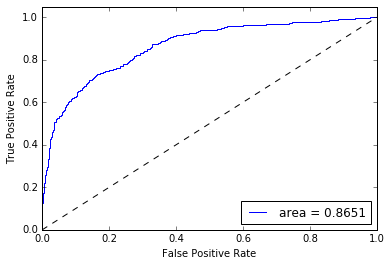

In [11]:
import datetime
from pytz import timezone
from dateutil import tz
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
np.random.seed(0)

#Setting up logic to identify timezone, weekend, and holidays
from_zone = tz.gettz('UTC')
to_zone = tz.gettz('America/Chicago')
weekend = set([5, 6])
cal = calendar()
holidays = cal.holidays(start='2011-04-07', end='2013-10-11')

'''
print ("from_zone:", from_zone)
print ("to_zone:", to_zone)
print ("weekend:", weekend)
print ("cal:", to_zone)
print ("holidays:", holidays)
'''

#Created new df for training data(numeric only)
train_data_numeric = np.zeros((len(train_data), 16))
dev_data_numeric =  np.zeros((len(dev_data), 16))

find_image = re.compile(r'(imgur\.com|\.jpg)')  #compile this to combine with other function

#####Process train data set###########################################################
ut = train_data['unix_timestamp_of_request_utc']
temp =  ut.apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
temp =  temp.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
utc =   temp.apply(lambda x: x.replace(tzinfo=from_zone))

'''
print ("ut:", ut[:5])
print ("temp:", temp[:5])
print ("utc:", utc[:5])
'''

temp = [] 
for i in utc:
    temp.append(i.astimezone(to_zone))
temp = pd.DataFrame(temp, columns=["T"])
    
train_data_numeric[:,0] = train_data['request_title'].apply(lambda x: len(x.split(' ')))  #Title length
train_data_numeric[:,1] = train_data['request_text'].apply(lambda x: len(x.split(' ')))   #Text length
train_data_numeric[:,2] = temp['T'].dt.month      #Month in integer
train_data_numeric[:,3] = temp['T'].dt.day > 15   #2nd 1/2 month
train_data_numeric[:,4] = temp['T'].dt.hour > 12  #Passed noon
train_data_numeric[:,5] = train_data['requester_upvotes_minus_downvotes_at_retrieval']
train_data_numeric[:,6] = train_data['requester_account_age_in_days_at_retrieval']
#Request during weekend
train_data_numeric[:,7] = ut.apply(lambda x: datetime.datetime.fromtimestamp(x).weekday() in weekend)
#Has Image
#experiment with request_text over request_text_edit_aware, and use post_was_edited below it
#train_data_numeric[:,8] = train_data['request_text_edit_aware'].apply(lambda x: 1 if find_image.findall(x) else 0 )
train_data_numeric[:,8] = train_data['request_text'].apply(lambda x: 1 if find_image.findall(x) else 0 )
#Requested date a holiday
train_data_numeric[:,9] = (train_data['unix_timestamp_of_request_utc']
                           .apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d')) 
                           .apply(lambda x: 1 if x in holidays else 0))

train_data_numeric[:,10] = train_data['post_was_edited']==1
train_data_numeric[:,11] = train_data['request_number_of_comments_at_retrieval']>1
train_data_numeric[:,12] = train_data['requester_number_of_posts_on_raop_at_retrieval']>1
# dont split on ; or ?, as it lowers the result
train_data_numeric[:,13] = train_data['request_text'].apply(lambda x: len(re.split(r'[.]',x)))>3 #proxy num sentences
train_data_numeric[:,14] = train_data['request_text'].apply(lambda x: avgNumWords(x))>15 #proxy avg num words per sentence
train_data_numeric[:,15] = monthsFrom2010(train_data['unix_timestamp_of_request_utc']) #months from raop creation in 12/2010

#train_data_numeric[:,11] = train_data['requester_number_of_comments_in_raop_at_retrieval']>1
#train_data_numeric[:,12] = train_data['requester_number_of_posts_at_retrieval']>1

#######process dev dataset######################################################
ut = dev_data['unix_timestamp_of_request_utc']
temp = ut.apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
temp = temp.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
utc =  temp.apply(lambda x: x.replace(tzinfo=from_zone))

temp = [] 
for i in utc:
    temp.append(i.astimezone(to_zone))
temp = pd.DataFrame(temp, columns=["T"])

dev_data_numeric[:,0] = dev_data['request_title'].apply(lambda x: len(x.split(' '))) 
dev_data_numeric[:,1] = dev_data['request_text'].apply(lambda x: len(x.split(' ')))
dev_data_numeric[:,2] = temp['T'].dt.month
dev_data_numeric[:,3] = temp['T'].dt.day > 15
dev_data_numeric[:,4] = temp['T'].dt.hour > 12 
dev_data_numeric[:,5] = dev_data['requester_upvotes_minus_downvotes_at_retrieval']
dev_data_numeric[:,6] = dev_data['requester_account_age_in_days_at_retrieval']>1
#Request during weekend
dev_data_numeric[:,7] = ut.apply(lambda x: datetime.datetime.fromtimestamp(x).weekday() in weekend) 
#Include Image
#experiment with request_text over request_text_edit_aware, and use post_was_edited below it
#dev_data_numeric[:,8] =  dev_data['request_text_edit_aware'].apply(lambda x: 1 if find_image.findall(x) else 0 )
dev_data_numeric[:,8] =  dev_data['request_text'].apply(lambda x: 1 if find_image.findall(x) else 0 )
dev_data_numeric[:,9] = (dev_data['unix_timestamp_of_request_utc']
                         .apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d')) 
                         .apply(lambda x: 1 if x in holidays else 0))

dev_data_numeric[:,10] = dev_data['post_was_edited']==1
dev_data_numeric[:,11] = dev_data['request_number_of_comments_at_retrieval']>1
dev_data_numeric[:,12] = dev_data['requester_number_of_posts_on_raop_at_retrieval']>1
# dont split on ; or ?, as it lowers the result
dev_data_numeric[:,13] = dev_data['request_text'].apply(lambda x: len(re.split(r'[.]',x)))>3  #proxy num sentences
dev_data_numeric[:,14] = dev_data['request_text'].apply(lambda x: avgNumWords(x))>15  #proxy avg num words per sentence
dev_data_numeric[:,15] = monthsFrom2010(dev_data['unix_timestamp_of_request_utc'])  #months from raop creation in 12/2010

#dev_data_numeric[:,11] = dev_data['requester_number_of_comments_in_raop_at_retrieval']>1
#dev_data_numeric[:,12] = dev_data['requester_number_of_posts_at_retrieval']>1

#[:, [0,1,2,3,4,7,8, 9]]
###Start Logistic Regresson on numeric data
logit = LogisticRegression(C=1, penalty = 'l2')
result = logit.fit(train_data_numeric, train_labels)

preds = logit.predict(dev_data_numeric)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')
pred_probas = logit.predict_proba(dev_data_numeric)

#How many positive case
print preds.sum()
print result.coef_

model_output(pred_probas, F_Score, preds)

In [12]:
train_text=train_data['request_text'].as_matrix()
train_title=train_data['request_title'].as_matrix()
train_all = train_text+train_title

dev_text=dev_data['request_text'].as_matrix()
dev_title=dev_data['request_title'].as_matrix()
dev_all = dev_text+dev_title

In [13]:
from scipy import sparse
from scipy.sparse import csr_matrix 
from scipy.sparse import coo_matrix, hstack

def first_preprocessor(s):
    #convert to lowercase
    s=s.lower()
    s=re.sub("[,.!?:;/~*]"," ",s)
    #remove duplicated 0s and 1s
    s=re.sub("[0-9]*","",s)
    #remove number longer than 5 digit
    s=re.sub("[0-9]{5,}","",s)
    #remove stem end with 'ly'
    s=re.sub("ly\s"," ",s)
    #remove plural form
    s=re.sub("s\s"," ",s)
    s=re.sub("s\Z"," ",s)
    #remove _ as the end of word
    s=re.sub("[_]+"," ",s)
    #remove _ as start of the word
    s=re.sub("\s[_]+"," ",s)
    #remove stem end with 'ness'
    s=re.sub("ness\s"," ",s)
    s=re.sub("ing\s"," ",s)
    #remove words that are too short
    s=re.sub("\s[0-9a-z]{1,2}\s"," ",s)
    s=re.sub("\s[0-9a-z]{1,2}\Z"," ",s)

    return s

def empty_preprocessor(s):
    return s


def tune_para(L1,L2):
    model_LG_L1 = LogisticRegression(penalty ='l1',C=L1)
    model_LG_L1.fit(word_matrix_process, train_labels)

    index=[]
    for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
        if z!=0:
            index.append(i)

    model_LG_L2 = LogisticRegression(penalty ='l2',C=L2 )
    model_LG_L2.fit(word_matrix_process[:,index], train_labels)
    
    f1_score=metrics.f1_score(dev_labels,model_LG_L2.predict(dev_matrix_process[:,index]),average='binary')
    
    return f1_score

#Result Testing for all Versions of the model:

###1)Baseline: no reprocess, no feature selection

In [14]:
def empty_preprocessor(s):
    return s


vectorizer_process = CountVectorizer(preprocessor =empty_preprocessor,analyzer='word',stop_words='english' )
word_matrix_process= vectorizer_process.fit_transform(train_all)
dev_matrix_process = vectorizer_process.transform(dev_all)


model_LG = LogisticRegression(penalty ='l2',C=12)
model_LG.fit(word_matrix_process, train_labels)


print('f1_score: %f' %metrics.f1_score(dev_labels,model_LG.predict(dev_matrix_process),average='binary'))
print('precision_score: %f' %metrics.precision_score(dev_labels,model_LG.predict(dev_matrix_process)))
print('recall_score: %f' %metrics.recall_score(dev_labels,model_LG.predict(dev_matrix_process)))

f1_score: 0.301158
precision_score: 0.346154
recall_score: 0.266515


###2)Add preprocessing and L1 feature selection

===>>No Preprocessing

In [15]:
# train_data_array=train_data['request_text'].as_matrix()
np.random.seed(0)
vectorizer_process = CountVectorizer(preprocessor = empty_preprocessor,analyzer='word',stop_words='english' )
word_matrix_process= vectorizer_process.fit_transform(train_all)
dev_matrix_process = vectorizer_process.transform(dev_all)

max=0
l1=0
l2=0
for i in range(500,700,10):
    for j in range(1,50,1):
        acc=tune_para(i,j)
        if acc>max:
            max=acc
            l1=i
            l2=j
#         print('When l1=%i ,l2=%i , taccuracy is %f' %(i,j,acc))
print('When l1=%i ,l2=%i , f1 score is %f' %(l1,l2,max))

When l1=550 ,l2=22 , f1 score is 0.334165


===>>Add Preprocessing

In [16]:
# train_data_array=train_data['request_text'].as_matrix()
vectorizer_process = CountVectorizer(preprocessor = first_preprocessor,analyzer='word',stop_words='english' )
word_matrix_process= vectorizer_process.fit_transform(train_all)
dev_matrix_process = vectorizer_process.transform(dev_all)

max=0
l1=0
l2=0
for i in range(500,600,10):
    for j in range(1,50,2):
        acc=tune_para(i,j)
        if acc>max:
            max=acc
            l1=i
            l2=j
print('When l1=%i ,l2=%i , f1 score is %f' %(l1,l2,max))

When l1=500 ,l2=9 , f1 score is 0.338272


###3)NLTK

In [17]:
import nltk
import string
import os

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
path = '/opt/datacourse/data/parts'
token_dict = {}
stemmer = SnowballStemmer("english", ignore_stopwords=True)

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

# error below on Derek's machine -- still need to download those packages

LookupError: 
**********************************************************************
  Resource u'corpora/stopwords' not found.  Please use the NLTK
  Downloader to obtain the resource:  >>> nltk.download()
  Searched in:
    - '/Users/dschan/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

#Current Best Logisitic Model:

Number of positive predictions: 242
Model F-Score = 0.5962 
Accuracy = 0.8379
accuracy_score: 0.838843
recall_score: 0.4624
roc_auc_score: 0.7157
pred_probas: [ 0.87150771  0.85976575  0.13588319 ...,  0.03083881  0.0549308   0.0774117 ]


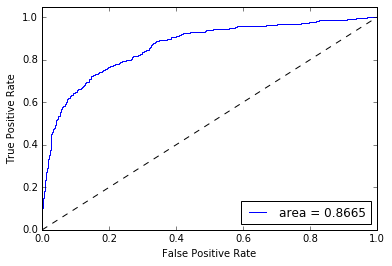

In [19]:
#Best non-ensemble method so far
np.random.seed(0)

vectorizer_process = CountVectorizer(analyzer='word',stop_words='english',preprocessor = first_preprocessor)
word_matrix_process= vectorizer_process.fit_transform(train_all)
dev_matrix_process = vectorizer_process.transform(dev_all)

model_LG_L1 = LogisticRegression(penalty ='l1',C=0.01)#C from the above test
model_LG_L1.fit(word_matrix_process, train_labels)

#Update the new index
index=[]
for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
    if z!=0:
        index.append(i)

# append along columns with axis=1. that is, append along x axis
all_data_train = np.append(word_matrix_process[:,index].toarray(), train_data_numeric, 1)

model_LG = LogisticRegression(penalty ='l2',C=0.1)#C from the above test
model_LG.fit(all_data_train, train_labels)

all_data_dev = np.append(dev_matrix_process[:,index].toarray(), dev_data_numeric, 1)

preds = model_LG.predict(all_data_dev)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')
pred_probas = model_LG.predict_proba(all_data_dev)

print "Number of positive predictions: %d" % (sum(preds))
#Call to display outputs
model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)

In [66]:
# check use of axis option
d1 = np.array([[1,2,3]])
d2 = np.array([[4,5,6]])
print
print np.append(d1,d2,axis=0)
print
print np.append(d1,d2,axis=1)

# check RAOP data shapes and features
print (word_matrix_process[:,index].toarray()).shape
print (train_data_numeric).shape
print (all_data_train).shape

print (word_matrix_process[:,index].toarray())
print
print (train_data_numeric)
print
print (all_data_train)


[[1 2 3]
 [4 5 6]]

[[1 2 3 4 5 6]]
(3975, 86)
(3975, 16)
(3975, 102)
[[0 1 0 ..., 0 2 0]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]

[[  19.  145.    7. ...,    1.    0.   19.]
 [   7.   93.    7. ...,    1.    1.    7.]
 [   9.   34.    8. ...,    0.    0.    8.]
 ..., 
 [  28.   25.    4. ...,    0.    0.   28.]
 [   7.   42.    8. ...,    1.    0.   33.]
 [   2.   17.    3. ...,    0.    1.   15.]]

[[  0.   1.   0. ...,   1.   0.  19.]
 [  0.   0.   0. ...,   1.   1.   7.]
 [  0.   0.   0. ...,   0.   0.   8.]
 ..., 
 [  0.   0.   0. ...,   0.   0.  28.]
 [  0.   0.   0. ...,   1.   0.  33.]
 [  0.   0.   0. ...,   0.   1.  15.]]


# Best Model with RandomForest

Number of trees in forest: 10
Number of positive predictions: 185
Model F-Score = 0.4487 
Accuracy = 0.7972
accuracy_score: 0.756757
recall_score: 0.3189
roc_auc_score: 0.6416
pred_probas: [ 0.9  0.4  0.2 ...,  0.1  0.1  0.2]

Number of trees in forest: 100
Number of positive predictions: 214
Model F-Score = 0.5666 
Accuracy = 0.8331
accuracy_score: 0.864486
recall_score: 0.4214
roc_auc_score: 0.6992
pred_probas: [ 0.75  0.66  0.23 ...,  0.12  0.09  0.08]

Number of trees in forest: 1000
Number of positive predictions: 222
Model F-Score = 0.5779 
Accuracy = 0.8355
accuracy_score: 0.860360
recall_score: 0.4351
roc_auc_score: 0.7052
pred_probas: [ 0.696  0.71   0.248 ...,  0.132  0.141  0.178]

Number of trees in forest: 7000
Number of positive predictions: 211
Model F-Score = 0.5662 
Accuracy = 0.8337
accuracy_score: 0.872038
recall_score: 0.4191
roc_auc_score: 0.6988
pred_probas: [ 0.71914286  0.686       0.22942857 ...,  0.12057143  0.12242857
  0.14628571]

Number of trees in forest:

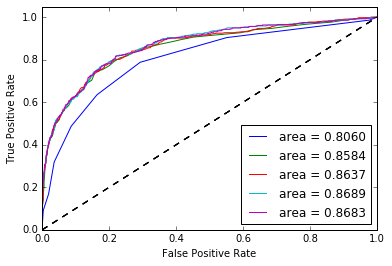

In [20]:
# Import the random forest package
from sklearn.ensemble import RandomForestClassifier 

#Best non-ensemble method so far
np.random.seed(0)

vectorizer_process = CountVectorizer(analyzer='word',stop_words='english',preprocessor = first_preprocessor)
word_matrix_process= vectorizer_process.fit_transform(train_all)
dev_matrix_process = vectorizer_process.transform(dev_all)

model_LG_L1 = LogisticRegression(penalty ='l1',C=0.1)#C from the above test
model_LG_L1.fit(word_matrix_process, train_labels)

#Update the new index
index=[]
for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
    if z!=0:
        index.append(i)

all_data_train = np.append(word_matrix_process[:,index].toarray(), train_data_numeric, 1)

for i in [10, 100, 1000, 7000, 10000]:

    # Create the random forest object which will include all the parameters
    forest = RandomForestClassifier(n_estimators = i)

    # Fit RandomForest
    # don't use transform method (at least not yet) -- which would reduce to best features -- 
    # as we want to keep and try these
    forest = forest.fit(all_data_train, train_labels)

    all_data_dev = np.append(dev_matrix_process[:,index].toarray(), dev_data_numeric, 1)

    # Take the same decision trees and run it on the test data
    preds = forest.predict(all_data_dev)

    #preds = model_LG.predict(all_data_dev)
    F_Score = metrics.f1_score(dev_labels, preds, average='binary')
    pred_probas = forest.predict_proba(all_data_dev)

    print "Number of trees in forest: %s" % (i)
    print "Number of positive predictions: %d" % (sum(preds))
    #Call to display outputs
    model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)
    print

In [100]:
#---------------------------------------------------
# https://www.kaggle.com/c/random-acts-of-pizza/submissions/attach
# prepare and output .csv file for Kaggle submission
# first, ensure final model was run only once on the Kaggle competition's test.json file
# their request_id and predicted probabilities of pizza are what need to be submitted
#---------------------------------------------------

#print dev_data["request_id"], pred_probas[:,1]

print type(dev_data["request_id"])
print type(pred_probas[:,1])

# convert from pd series to np
request_id = to_np(dev_data["request_id"])
proba_pizza = pred_probas[:,1]


print request_id.shape
print proba_pizza.shape
print

print request_id
print proba_pizza

request_id = np.array([request_id]).T
proba_pizza = np.array([proba_pizza]).T

# https://www.kaggle.com/c/random-acts-of-pizza/submissions/attach
# expectation is 1631 predictions. No need to reshuffle, given the data was shuffled at the start of project
request_id, proba_pizza = request_id[:1631], proba_pizza[:1631]

# append along columns with axis=1. that is, append along x axis
kaggle = np.append(request_id, proba_pizza, 1)

'''
print request_id, proba_pizza
kaggle.tofile('/Users/dschan/Downloads/W207-Kaggle-Project/kaggle.csv',sep=',')
np.savetxt('/Users/dschan/Downloads/W207-Kaggle-Project/kaggle.csv', kaggle, delimiter=",")
'''

# transform to pd and export to csv
kaggle = pd.DataFrame(kaggle,columns=['request_id','requester_received_pizza'])
kaggle.to_csv('/Users/dschan/Downloads/W207-Kaggle-Project/lmd_kaggle_pizza.csv', header=True, index=False, sep=',')

<class 'pandas.core.series.Series'>
<type 'numpy.ndarray'>
numpy.ndarray:
<type 'numpy.ndarray'>
(1696,)
[u't3_qysgy' u't3_toxi0' u't3_12s9wy']

(1696,)
(1696,)

[u't3_qysgy' u't3_toxi0' u't3_12s9wy' ..., u't3_1lrh6u' u't3_11h6ki'
 u't3_1896rw']
[ 0.7156  0.6854  0.2187 ...,  0.1236  0.12    0.1572]


###4)PCA

In [ ]:
#get a list of features based on the L1 regularization, instead of inputting all words into PCA to improve the speed
vectorizer_process = CountVectorizer(preprocessor = empty_preprocessor,analyzer='word',stop_words='english' )
word_matrix_process= vectorizer_process.fit_transform(train_all)
dev_matrix_process = vectorizer_process.transform(dev_all)

model_LG_L1 = LogisticRegression(penalty ='l1',C=560) #C from the above test
model_LG_L1.fit(word_matrix_process, train_labels)

index=[]
for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
    if z!=0:
        index.append(i)


In [ ]:
from sklearn.decomposition import PCA

i=1000
pca_mod = PCA(n_components = i)
word_matrix_process_pca=pca_mod.fit_transform(word_matrix_process.toarray()[:,index])
print('For the first %i element, %f of the total variance in the training data is explained ' %(i,sum(pca_mod.explained_variance_ratio_)) )
plt.plot(pca_mod.explained_variance_ratio_)

In [47]:
dev_matrix_process_pca=pca_mod.transform(dev_matrix_process.toarray()[:,index])

model_LG_L2 = LogisticRegression(penalty ='l2',C=19 )#C from the above test
model_LG_L2.fit(word_matrix_process_pca, train_labels)

print('f1_score: %f' %metrics.f1_score(dev_labels,model_LG_L2.predict(dev_matrix_process_pca),average='binary'))
print('recall_score: %f' %metrics.recall_score(dev_labels,model_LG_L2.predict(dev_matrix_process_pca)))
print('precision_score: %f' %metrics.precision_score(dev_labels,model_LG_L2.predict(dev_matrix_process_pca)))

f1_score: 0.316069
recall_score: 0.271071
precision_score: 0.378981
